In [1]:
import math
import pandas as pd
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
from scipy.spatial import distance
import io
import time#for recording time 
import sys #for getting size of object
!pip install texttable
from texttable import Texttable
import mysql.connector

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#importing data form github
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/skewness.csv'
skewness_df=pd.read_csv(url4,header=None,engine='python')
url5='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/Age_exact.csv'
age_exact_df=pd.read_csv(url5,header=0,engine='python')
url6='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/mortality.csv'
death_rate_df=pd.read_csv(url6,header=0,engine='python')

### *connecting to MySQL

In [3]:

cnx = mysql.connector.connect(user='nima', password='Mysqlpass1400@',
                              host='127.0.0.1',
                              database='MPH')

cursor = cnx.cursor(buffered=True)

In [4]:
#defining class person for storing nodes information
class person:
    
    def __init__(self,home,school,work,others,work_r,others_r,age_E,disease_status,disease_dur):
        
        self.home=home
        self.school=school
        self.work=work
        self.others=others
        self.work_r=work_r
        self.others_r=others_r
        self.age_E=age_E
        self.disease_status=disease_status
        self.disease_dur=disease_dur
        
    def age_group(self):
        
        bucket = False
    
        for i in age_groups :
            if bucket== False and self.age_E <= i[2] and self.age_E >=i[1]:
                group=i[0]
                bucket=True
        return(group)
        


In [5]:
age_groups=[['0_4', 0, 4],['5_9', 5, 9],['10_14', 10, 14],['15_19', 15, 19],['20_24', 20, 24],['25_29', 25, 29],['30_34', 30, 34],['35_39', 35, 39],['40_44', 40, 44],['45_49', 45, 49],['50_54', 50, 54],['55_59', 55, 59],['60_64', 60, 64],['65_69', 65, 69],['70_74', 70, 74],['75+', 75,200]] 

In [6]:
#rebuilding graph form mysql

graph={}

cursor.execute('select * from %s'%('Graph'))

for (node,home,school,work,others,work_r,others_r,age_E) in cursor:
    contacts_list=[]
    for setting in [home,school,work,others]:
        contacts_list.append(list(map(lambda x:int(x),setting.split('/')[:-1])))
    graph[node]=person(contacts_list[0],contacts_list[1],contacts_list[2],contacts_list[3],work_r,others_r,age_E,0,0)       

In [7]:
#age grouping nodes
nodes_age_grouped={}
for node in graph.keys():
    age=graph[node].age_group()
    if age in list(nodes_age_grouped.keys()):
        nodes_age_grouped[age].append(node)
    else:
        nodes_age_grouped[age]=[node]
        

In [8]:
#importing rules and rules_sum
#importing rules_data from .csv to nested dictionary
rules_data={}  # rules_data contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules_data[location[o]]=temp_1.copy()     
    
    
#transforming rules_data to rules so it will be symetrical
#It should be symetrical for building undirected graph

rules=dict()



for i in rules_data.keys():
    rules[i]=dict()
    for j in rules_data[i].keys():
        rules[i][j]=dict() 
        for k in rules_data[i][j].keys():

            total_j_k_contact=(rules_data[i][j][k]*len(nodes_age_grouped[j])+(rules_data[i][k][j]*len(nodes_age_grouped[k])))
            rules[i][j][k]=(total_j_k_contact/2)/len(nodes_age_grouped[j])
                
#claculating how many contact a person has with all age groups in the setting
#calculating how many 'connectons' is required for the contacts with specific frequency
rules_sum=dict()
for s in rules.keys():
    rules_sum[s]=dict()
    for a in rules[s].keys():
        t=0
        for j in rules[s][a].keys():
            t+=rules[s][a][j]
        rules_sum[s][a]=t

In [9]:
#the function for transmission of disease
def transmission(graph):
    
    #finding the infected nodes
    infected=list(filter(lambda x:graph[x].disease_status==1,graph.keys()))
    
    
    for node in infected :
        for connections in [graph[node].home,graph[node].work,graph[node].school,graph[node].others]:
        #daily contacts
            for neighbor in connections:
                #if the neighbor is not already infected
                if graph[neighbor].disease_status==0:
                    r=random.random()
                    #probaility transmission
                    p=.02
                    if r<p :
                        graph[neighbor].disease_status=1
                        #duration of infection
                        graph[neighbor].disease_dur=10
                    
        #random contacts
        age_node=graph[node].age_group()
        for setting in ['work','others']:
            
            if setting == 'work':
                random_connection=graph[node].work_r
            elif setting == 'others':
                random_connection=graph[node].others_r
                
            for i in range(random_connection):
                contact=False
                while contact == False :
                    age_neighbor=random.choice(list(nodes_age_grouped.keys()))
                    prob_connection=rules[setting][age_node][age_neighbor]/(rules_sum[setting][age_node])
                    r=random.random()
                    if prob_connection<r:
                        neighbor=random.choice(nodes_age_grouped[age_neighbor])
                        contact=True
                        if graph[neighbor].disease_status==0:
                            r=random.random()
                            #probaility transmission
                            p=.02
                            if r<p:
                                graph[neighbor].disease_status=1
                                #duration of infection
                                graph[neighbor].disease_dur=10 
                            
        #one day passes form disease duration
        graph[node].disease_dur-=1
        if graph[node].disease_dur==0:
            graph[node].disease_status=2
            

In [10]:
#function that returns the graph before pandemic
def reset_graph(graph):
    for node in graph.keys():
        graph[node].disease_dur==0
        graph[node].disease_status=0

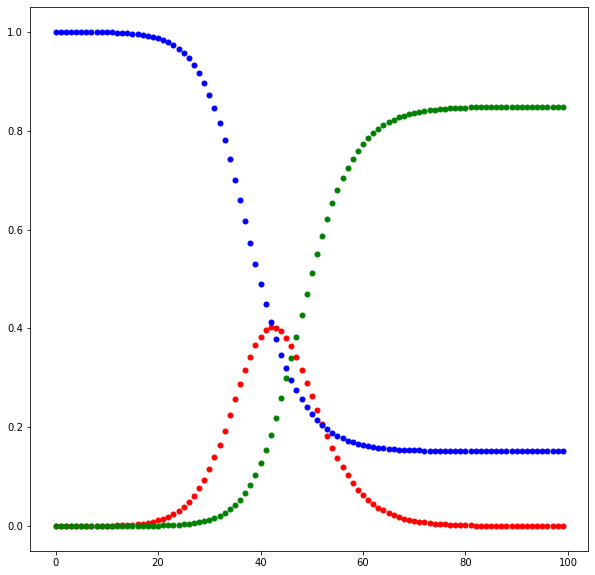

In [19]:
#simulation of the pandemic for D days with N initial infected cases
plt.rcParams["figure.figsize"] = (10,10)

D=100
N=10
#reset graph
reset_graph(graph)
for i in range(N):
    node=random.choice(list(graph.keys()))
    graph[node].disease_status=1
    #duration of infection
    graph[node].disease_dur=10 
    
for i in range(D):
    transmission(graph)
    infected=len(list(filter(lambda x:graph[x].disease_status==1,graph.keys())))/len(list(graph.keys()))
    suspectible=len(list(filter(lambda x:graph[x].disease_status==0,graph.keys())))/len(list(graph.keys()))
    immune=len(list(filter(lambda x:graph[x].disease_status==2,graph.keys())))/len(list(graph.keys()))
    plt.plot(i,infected,'r.',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,immune,'g.',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,suspectible,'b.',linewidth=2, markersize=10,alpha=1)
    
    
    
plt.show()
    